In [63]:
#readFeats
import numpy as np
import pandas as pd
import sklearn
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import hyperopt
from hyperopt import  hp, fmin, tpe, STATUS_OK, Trials
import time
xgb.__file__


'/home/xuhuang/anaconda2/lib/python2.7/site-packages/xgboost/__init__.pyc'

In [64]:
inj = pd.read_csv("../Data/Injected_feat_files_10000_fixed.csv", index_col=0)
inv = pd.read_csv("../Data/Inverted_feat_files_fixed_detrended.csv", index_col=0)
inj_periods = np.loadtxt("../../Training/simulation/injection/injection.txt", dtype= str, delimiter=",")[:10000, 3].astype("float64")
inj_SNR = np.loadtxt("../Data/SNR_10000_corrected.txt")[:10000]
inj_tol = np.loadtxt("../Data/period_harmonics_10000_inj_signals_tol_5x5.txt")

#kois
#koi = pd.read_csv("../Data/KOI_feat_files_4251_fixed_ordered.csv", index_col=0)
#koi_tol = np.loadtxt("../Data/period_harmonics_4251_koi_signals_tol_5x5_ordered.txt")
#koi_SNR = np.loadtxt("../Data/SNR_feats_KOIS_4251_fixed.txt")
#koi_periods = np.loadtxt("../Data/koi_periods.txt")

koi = pd.read_csv("../Data/KOI_feat_files_3080_fixed_ordered_try2.csv", index_col =0 )
koi_tol = np.loadtxt("../Data/period_harmonics_3080_koi_signals_tol_5x5_ordered_try2.txt")
koi_SNR = np.loadtxt("../Data/SNR_feats_KOIS_3080_fixed_try2.txt")
koi_periods = np.loadtxt("../Data/koi_periods_try2.txt")

#non pimary koi
non_koi = pd.read_csv("../Data/KOI_non_prim_feat_files_20000_new_detrending.csv", index_col=0)[4000:5000]
test_non_kois = pd.read_csv("../Data/KOI_non_prim_feat_files_20000_new_detrending.csv", index_col=0)[5000:15000]

In [65]:
#make cuts to inj determine correct y values
ped_constraint = 3 # perido cut
SNR_cut =6
inj_enough_transits = ((26/inj_periods) > ped_constraint).astype(int)
inj_low_tol = ((inj_tol[:,0]==1)+(inj_tol[: ,1]==1) + (inj_tol[:,0] == inj_tol[:,1])).astype(int)

print "Tolerance Cut", len(np.where(inj_low_tol==1)[0])
print "SNR Cut", len(np.where(inj_SNR>SNR_cut)[0])
inj_true_trans = ((inj_SNR>=SNR_cut)*(inj_tol[:,2]<0.002)*(inj_low_tol==1)*(inj_enough_transits)).astype(int)
print "Retained Transits", len(np.where(inj_true_trans==1)[0])


#koi_cuts
koi_enough_trans = (26/koi_periods >= ped_constraint).astype(int)
koi_low_tol = ((koi_tol[:,0]==1)+(koi_tol[: ,1]==1) + (koi_tol[:,0] == koi_tol[:,1])).astype(int)
indices = np.where(koi_SNR[:,0] == 2989404)[0]
print indices
koi_low_tol[indices] = 1  

koi_true_trans = ((koi_SNR[:, -1]>=SNR_cut)* (koi_tol[:,2]<0.002) * (koi_enough_trans==1)).astype(int)
print "Retained Transits", len(np.where(koi_true_trans==1)[0]), "from", koi.shape[0]


#append Y values
inj["Y"] = inj_true_trans
inv["Y"] = np.zeros(inv.shape[0])
#koi["Y"] = koi_true_trans
non_koi["Y"] = np.zeros(non_koi.shape[0])

object_labels = np.hstack([np.ones(inj.shape[0]),np.zeros(inv.shape[0])+2,  np.zeros(non_koi.shape[0])+4])
total_signals = pd.concat([inj, inv,  non_koi], axis = 0)


#object_labels = np.hstack([np.ones(inj.shape[0]),  np.zeros(non_koi.shape[0])+4])
#total_signals = pd.concat([inj,   non_koi], axis = 0)


#koi["BLS_P"]
# 1 inj , 2 inv, 3 koi, 4 non kois
drop_column =  ["BLS_Npointsaftertransit_1_0", "BLS_Npointsintransit_1_0", "BLS_Npointsbeforetransit_1_0",
                "BLS_OOTmag_1_0", "BLS_Tc_1_0", "BLS_Period_1_0"]
total_signals = total_signals.drop(drop_column, axis = 1)
test_non_kois = test_non_kois.drop(drop_column, axis=1)
koi = koi.drop(drop_column, axis = 1)
labels = total_signals["Y"]
del total_signals["Y"]
total_signals.head(1)

Tolerance Cut 9565
SNR Cut 9255
Retained Transits 6215
[913 914 915 916 917 918 919 920 921 922 923 924]
Retained Transits 690 from 3080


,mod_sig_pri_dv,mod_sig_sec_dv,mod_sig_ter_dv,mod_sig_pos_dv,mod_fa1_dv,mod_fa2_dv,mod_fred_dv,modshiftval1_dv,modshiftval2_dv,modshiftval3_dv,...,BLS_Qtran_1_0,BLS_Qingress_1_0,BLS_i1_1_0,BLS_i2_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Ntransits_1_0,BLS_Rednoise_1_0,BLS_Whitenoise_1_0,BLS_SignaltoPinknoise_1_0
0,0.00028,-9.999884,0.000098,-0.000186,2.991073,2.538906,1.040623,-2.990804,-2.538725,-2.53844,...,0.08623,0.18903,0.35772,0.44395,-0.00001,0.31843,4.0,0.00004,0.00031,7.72038


In [66]:
shuffleX, shuffleY , shuffle_labels= shuffle(total_signals, labels, object_labels, random_state =0)
shuffleX = shuffleX.reset_index(drop = True)
shuffleY = shuffleY.reset_index(drop = True)

print shuffleX.shape, shuffleY.shape #, train_label.shape

trainX, testX, trainY, testY, train_label, test_label = train_test_split(shuffleX, shuffleY, shuffle_labels, stratify =shuffle_labels, test_size = 0.20,random_state = 0 )

print "Strong Transits in training" , len(np.where([(trainY==1) & (train_label==1)])[0]) 
print "Weak Transits in training" , len(np.where([(trainY==0) & (train_label==1)])[0]) 
print "Inverted Signals in training" , len(np.where([(trainY==0) & (train_label==2)])[0]) 
print "Non kois in Training", len(np.where([(trainY==0) & (train_label==4)])[0]) ,"\n"
print "Strong Transits in testing" , len(np.where([(testY==1) & (test_label==1)])[0]) 
print "Weak Signals in testing" , len(np.where([(testY==0) & (test_label==1)])[0]) 
print "Inverted Signals in testing" , len(np.where([(testY==0) & (test_label==2)])[0]) 
print "Non kois in Testing", len(np.where([(testY==0) & (test_label==4)])[0]) 
#print "\n",shuffleX.columns.values

(26000, 29) (26000,)
Strong Transits in training 4979
Weak Transits in training 3021
Inverted Signals in training 12000
Non kois in Training 800 

Strong Transits in testing 1236
Weak Signals in testing 764
Inverted Signals in testing 3000
Non kois in Testing 200


In [67]:
xgbc = XGBClassifier(seed = 0, max_depth=20, min_child_weight=5, subsample=0.95, colsample_bytree=0.9, n_estimators=500, scale_pos_weight=30, learning_rate=0.02 )
xgbc.fit(trainX, trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=20,
       min_child_weight=5, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=30, seed=0, silent=True, subsample=0.95)

In [68]:
preds = xgbc.predict(testX)
print metrics.average_precision_score(testY, preds)
print "Strong Injections detected", len(np.where((preds==1)&(test_label==1)&(testY==1))[0]),"from", len(np.where((test_label==1)&(testY==1))[0])
print "Weak Injections detected with period cut", len(np.where((preds==1)&(test_label==1)&(testY==0))[0]),"from", len(np.where((test_label==1)&(testY==0))[0])

print "Inverted Rejected", len(np.where((preds==0)&(test_label==2)&(testY==0))[0]),"from", len(np.where((test_label==2)&(testY==0))[0])
#print "Weak Injections detected with period cut", len(np.where((preds==1)&(test_label==1)&(testY==0))[0]),"from", len(np.where((test_label==1)&(testY==0))[0])

print "NON_KOI_Rejected", len(np.where((preds==0)&(test_label==4)&(testY==0))[0]),"from", len(np.where((test_label==4)&(testY==0))[0])
#print "Weak Injections detected with period cut", len(np.where((preds==1)&(test_label==1)&(testY==0))[0]),"from", len(np.where((test_label==1)&(testY==0))[0])
preds_non_kois = xgbc.predict(test_non_kois)
print "NON_kois_test_set rejected", len(np.where(preds_non_kois==0)[0]), "from 10000" 

0.983999055061
Strong Injections detected 1218 from 1236
Weak Injections detected with period cut 24 from 764
Inverted Rejected 3000 from 3000
NON_KOI_Rejected 198 from 200
NON_kois_test_set rejected 9868 from 10000


Unique starts 283
nan 3.0 0.252043706641 6.842939
Stars detected 120
Stars Missed 163
SNR



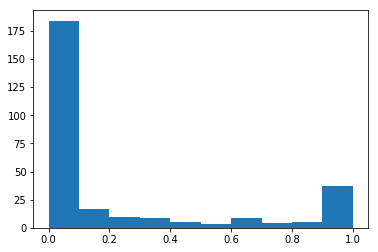

In [46]:
#print trainX.columns.values
#print koi.columns.values

preds =xgbc.predict(koi)
star_list_ids = np.unique(koi_SNR[:,0])

partially_detected = np.zeros_like(star_list_ids)
detection_counts = np.zeros_like(star_list_ids)
normalized_detection_counts = np.zeros_like(star_list_ids)
not_detected = np.zeros_like(star_list_ids)
should_be_detected = np.zeros_like(star_list_ids)


star_SNR =np.zeros_like(star_list_ids)
star_tol = np.zeros_like(star_list_ids)
star_transits = np.zeros_like(star_list_ids)
star_period = np.zeros_like(star_list_ids)

print "Unique starts" ,len(star_list_ids)
#print koi_SNR
for i,id_num in enumerate(star_list_ids):
    indices = np.where(id_num == koi_SNR[:,0])[0]
    #print indices
    if  preds[indices].sum() >=1:
        partially_detected[i] = star_list_ids[i]
    else  :
        not_detected[i] = star_list_ids[i]
    detection_counts[i]=preds[indices].sum()
    normalized_detection_counts[i] = np.nansum(preds[indices].sum()/ len(np.where(preds[indices]!=np.nan)[0]))
    should_be_detected[i] = np.mean(koi_true_trans[indices])
    
    
    #other params
    star_SNR[i] = np.median(koi_SNR[indices,2])
    
    star_transits[i] = np.median(26//koi_periods[indices])
    star_tol[i] = np.median(koi_tol[indices,2])
    star_period[i] = np.mean(koi_periods[indices])
    if id_num==10736489:
        print star_SNR[i], star_transits[i], star_tol[i], star_period[i]
        star_SNR[i]= 0

print "Stars detected", len(np.where(partially_detected!=0)[0])

plt.hist(normalized_detection_counts)

print "Stars Missed" , len(not_detected[np.where(not_detected!=0)[0]])
print "SNR\n"

#iterate over msised stars
#for i, id_num in enumerate(not_detected[np.where(not_detected!=0)[0]]):
#    indices = np.where(id_num == koi_SNR[:,0])[0]
#    print "ID:", id_num
#    print "KOI_SNR:", koi_SNR[indices,2]
#    print "KOI_SNR_MEAN:", np.mean(koi_SNR[indices,2])
#    print "YLabels", koi_true_trans[indices],  "\n"



Weak stars detected with low period err: 3 from 5
Weak stars detected with high period err: 13 from 130
Total Strong stars detected with low period err: 75 from 96
Strong stars detected with low period err with up to two transits: 3 from 13
Strong stars detected with low period err with 2 to 3 transits per segment: 5 from 16
Strong stars detected with low period err and tight transit cut: 67 from 67
Strong stars detected with high period err: 29 from 52
6 3
[  2304320.   2438513.   2853446.   4278221.   4857213.   5020319.
   5695396.   6442340.   6541920.   6779260.   7202957.   7887791.
   8750043.   8802165.   9266431.   9489524.   9950612.  10024701.
  10252275.  10545066.  10676014.  11253711.  11568987.]
[  2989404.   3446746.   3541946.   4164922.   4349442.   4644604.
   5185897.   5794570.   5796675.   5941160.   6021275.   6289257.
   7115785.   7419318.   7509886.   7976520.   8552719.   8738735.
   8766650.   8962094.   9002278.  10130039.  10154388.  10984090.
  11241912. 

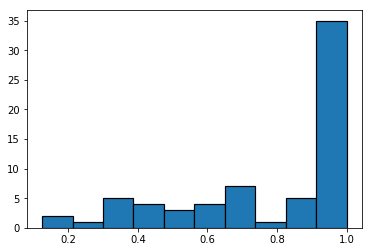

In [47]:
import warnings
warnings.simplefilter('ignore')

print "Weak stars detected with low period err:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR<SNR_cut))[0]), \
     "from", len(np.where( (star_tol<0.002) &(star_SNR<SNR_cut))[0])
print "Weak stars detected with high period err:", len(np.where( (partially_detected>0)& (star_tol>0.002) & (star_SNR<SNR_cut))[0]) ,\
 "from", len(np.where( (star_tol>0.002) &(star_SNR<SNR_cut))[0])


print "Total Strong stars detected with low period err:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut))[0]), \
 "from", len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut) )[0])

    
print "Strong stars detected with low period err with up to two transits:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut) &(star_period>13))[0]), \
 "from", len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut) &(star_period>13))[0])
    
    
print "Strong stars detected with low period err with 2 to 3 transits per segment:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut) & (star_period>8.67) & (star_period<13))[0]), \
 "from", len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut) & (star_period>8.67) & (star_period<13))[0])
    
print "Strong stars detected with low period err and tight transit cut:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut)& (star_period<8.67))[0]), \
 "from", len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut)  &(star_period<8.67) )[0])

print "Strong stars detected with high period err:", len  (np.where( (partially_detected>0)& (star_tol>0.002) &(star_SNR>6))[0]), \
 "from", len(np.where( (star_tol>0.002) &(star_SNR>SNR_cut))[0])
    
missed_strong_stars = star_list_ids[np.where( (star_tol<0.002) &(star_SNR>SNR_cut)& (partially_detected==0))[0]]
missed_strong_stars_period_cut = star_list_ids[np.where( (star_tol<0.002) &(star_SNR>SNR_cut)& (partially_detected==0)& (star_period<8.67))[0]] 
detected_strong_stars = star_list_ids[np.where( (star_tol<0.002) &(star_SNR>SNR_cut)& (partially_detected!=0)& (star_period<8.67))[0]] 

print SNR_cut, ped_constraint

strong_Star_high_p_error_missed = star_list_ids[np.where((star_tol>0.002) & (star_SNR>6) & (not_detected!=0) )[0]]
strong_Star_high_p_error_caught = star_list_ids[np.where((star_tol>0.002) & (star_SNR>6) & (partially_detected!=0) )[0]]
print strong_Star_high_p_error_missed
print strong_Star_high_p_error_caught
#print strong_Star_high_p_error
print missed_strong_stars
#print missed_strong_stars_period_cut
#plt.hist(star_period)
#print star_period[np.where( (star_tol<0.002) &(star_SNR>6)& (partially_detected==0)&(star_period<8.67))[0]] 
strong_star_detection_counts = normalized_detection_counts[np.where( (star_tol<0.002) &(star_SNR>SNR_cut)  &(star_period<8.67) )[0]]
print strong_star_detection_counts#normalized_detection_counts[np.where( (star_tol<0.002) &(star_SNR>SNR_cut)  &(star_period<8.67) )[0]]
plt.hist(strong_star_detection_counts,        edgecolor='black', linewidth=1.2)
print len(np.where(strong_star_detection_counts==1)[0])

(100,) (100,)
Detected: 70 from 72 at SNR 0.0
[ 8278371.  9221517.]
Detected: 70 from 72 at SNR 1.0101010101
[ 8278371.  9221517.]
Detected: 70 from 72 at SNR 2.0202020202
[ 8278371.  9221517.]
Detected: 70 from 72 at SNR 3.0303030303
[ 8278371.  9221517.]
Detected: 70 from 72 at SNR 4.0404040404
[ 8278371.  9221517.]
Detected: 70 from 72 at SNR 5.05050505051
[ 8278371.  9221517.]
Detected: 67 from 67 at SNR 6.06060606061
[]
Detected: 64 from 64 at SNR 7.07070707071
[]
Detected: 63 from 63 at SNR 8.08080808081
[]
Detected: 55 from 55 at SNR 9.09090909091
[]
Detected: 52 from 52 at SNR 10.101010101
[]
Detected: 51 from 51 at SNR 11.1111111111
[]
Detected: 45 from 45 at SNR 12.1212121212
[]
Detected: 43 from 43 at SNR 13.1313131313
[]
Detected: 38 from 38 at SNR 14.1414141414
[]
Detected: 34 from 34 at SNR 15.1515151515
[]
Detected: 33 from 33 at SNR 16.1616161616
[]
Detected: 32 from 32 at SNR 17.1717171717
[]
Detected: 30 from 30 at SNR 18.1818181818
[]
Detected: 27 from 27 at SNR 19.1

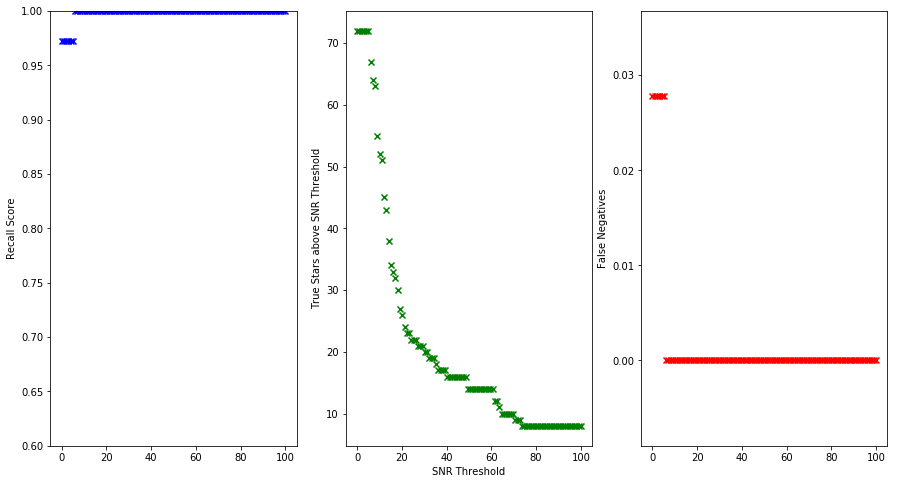

In [49]:
x = np.linspace(0,100,100)
y = np.zeros(x.shape[0])
y_total_count = np.zeros_like(y)
y_missed = np.zeros_like(y)
print x.shape, y.shape
for i, val in enumerate(x):
    SNR_cut_val = val
    y[i] = len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut_val)& (star_period<8.67))[0]) / float(len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) )[0]))
    print "Detected:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>SNR_cut_val)& (star_period<8.67))[0]),  "from",  (len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) )[0])), "at SNR", val
    print star_list_ids[np.where( (not_detected!=0)& (star_tol<0.002) &(star_SNR>SNR_cut_val)& (star_period<8.67))[0]]
    y_total_count[i] = len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) )[0])
    y_missed[i] = len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) & (not_detected!=0) )[0]) /float(len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67)  )[0]))
fig = plt.figure(figsize=((15,8)))
ax = fig.add_subplot("131")
ax.set_ylabel("Recall Score")
ax.scatter(x, y, marker = "x", color = "blue")

ax2= fig.add_subplot("132")
ax2.scatter(x, y_total_count, marker = "x", color = "green")
ax2.set_ylabel("True Stars above SNR Threshold")

ax3= fig.add_subplot("133")
ax3.scatter(x, y_missed, marker = "x", color = "red")
ax3.set_ylabel("False Negatives")
#plt.scatter(x, y_total_count, marker)
#plt.scatter(data[:,0], data[:,2], marker = ".")
#axes = plt.gca()
#axes.set_ylim([0.6, 1])
ax.set_ylim([0.6,1])
#ax2.set_xlim([0,40])
ax2.set_xlabel("SNR Threshold")

NAN SRN (array([], dtype=int64),)
[  22.39802964    1.90874681    0.          333.11042276    2.9717666 ]
[ 10676014.  10722485.  10736489.  10748390.  10777591.]
211 72 211


(0, 25)

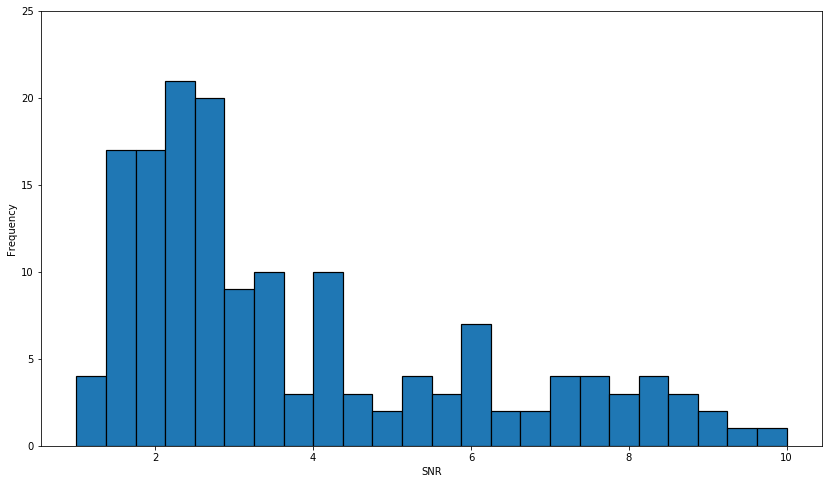

In [71]:
#create SNR hoist of total 283 stars minus the 72 strong signals passing strict period cut and period error cut. 
strong_stars_low_err = star_SNR[np.where( (star_tol<0.002)   &(star_period<8.67) )[0]]
weak_err_Stars = star_SNR[np.where( (star_tol> 0.002) + (star_period>8.67) )[0] ]
weak_star_detections = normalized_detection_counts[np.where( (star_tol> 0.002) + (star_period>8.67) )[0]]
print "NAN SRN", np.where(star_SNR[-100:]==np.nan)
print star_SNR[-50:-45]
print star_list_ids[-50:-45]
#/ float(len(np.where( (star_tol<0.002) &(star_SNR>SNR_cut_val)  &(star_period<8.67) )[0]))
print len(weak_err_Stars), len(strong_stars_low_err), len(weak_star_detections)

#print weak_err_Stars
plt.figure(figsize = (14, 8))
plt.hist(weak_err_Stars, edgecolor='black', linewidth=1.2, bins = np.linspace(1, 10, 25))
plt.ylabel("Frequency")
plt.xlabel("SNR")
plt.ylim([0,25])
#plt.figure()
#plt.hist(weak_star_detections)

In [ ]:
#create pd frame of all segments of stars dIIetected and stars missed
missed_strong_star_feats = np.empty(shape = (0,29))

for star_ID in missed_strong_stars:
    indices = np.where(star_ID==koi_SNR[:,0])
    print koi.loc[indices].shape
    print missed_strong_star_feats
    missed_strong_star_feats = np.append(missed_strong_star_feats, koi.loc[indices], axis = 0)
    
    print missed_strong_stars
    #break
#koi.head()
print missed_strong_star_feats.shape


In [ ]:
#do quick tuning, is the model just using poor parameters if its missing half of the strong signals?
#print star_SNR[np.where(star_list_ids== 2853446)[0]]
#print preds[np.where(koi_SNR[:,0] == 2853446)[0]]

#create pd frame of all segments of stars dIIetected and stars missed
detected_strong_star_feats = np.empty(shape = (0,29))

for star_ID in detected_strong_stars:
    indices = np.where(star_ID==koi_SNR[:,0])
    #print koi.loc[indices].shape
    detected_strong_star_feats = np.append(detected_strong_star_feats, koi.loc[indices], axis = 0)
        #print missed_strong_stars
    #break
#koi.head()
print detected_strong_star_feats.shape

#print missed_strong_stars_segments
#koi_SNR[0,:] in missed_strong_stars

In [ ]:
feat_imp = pd.Series(xgbc.booster().get_fscore()  ).sort_values(ascending =False)
feat_sum = feat_imp.values.sum()
feat_imp = feat_imp/feat_sum
feat_imp.plot(kind = "bar", figsize=((12, 8)))